In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv("MSFT.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061434,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063628,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064725,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063079,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061982,47894400


In [6]:
df.shape

(9083, 7)

In [3]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

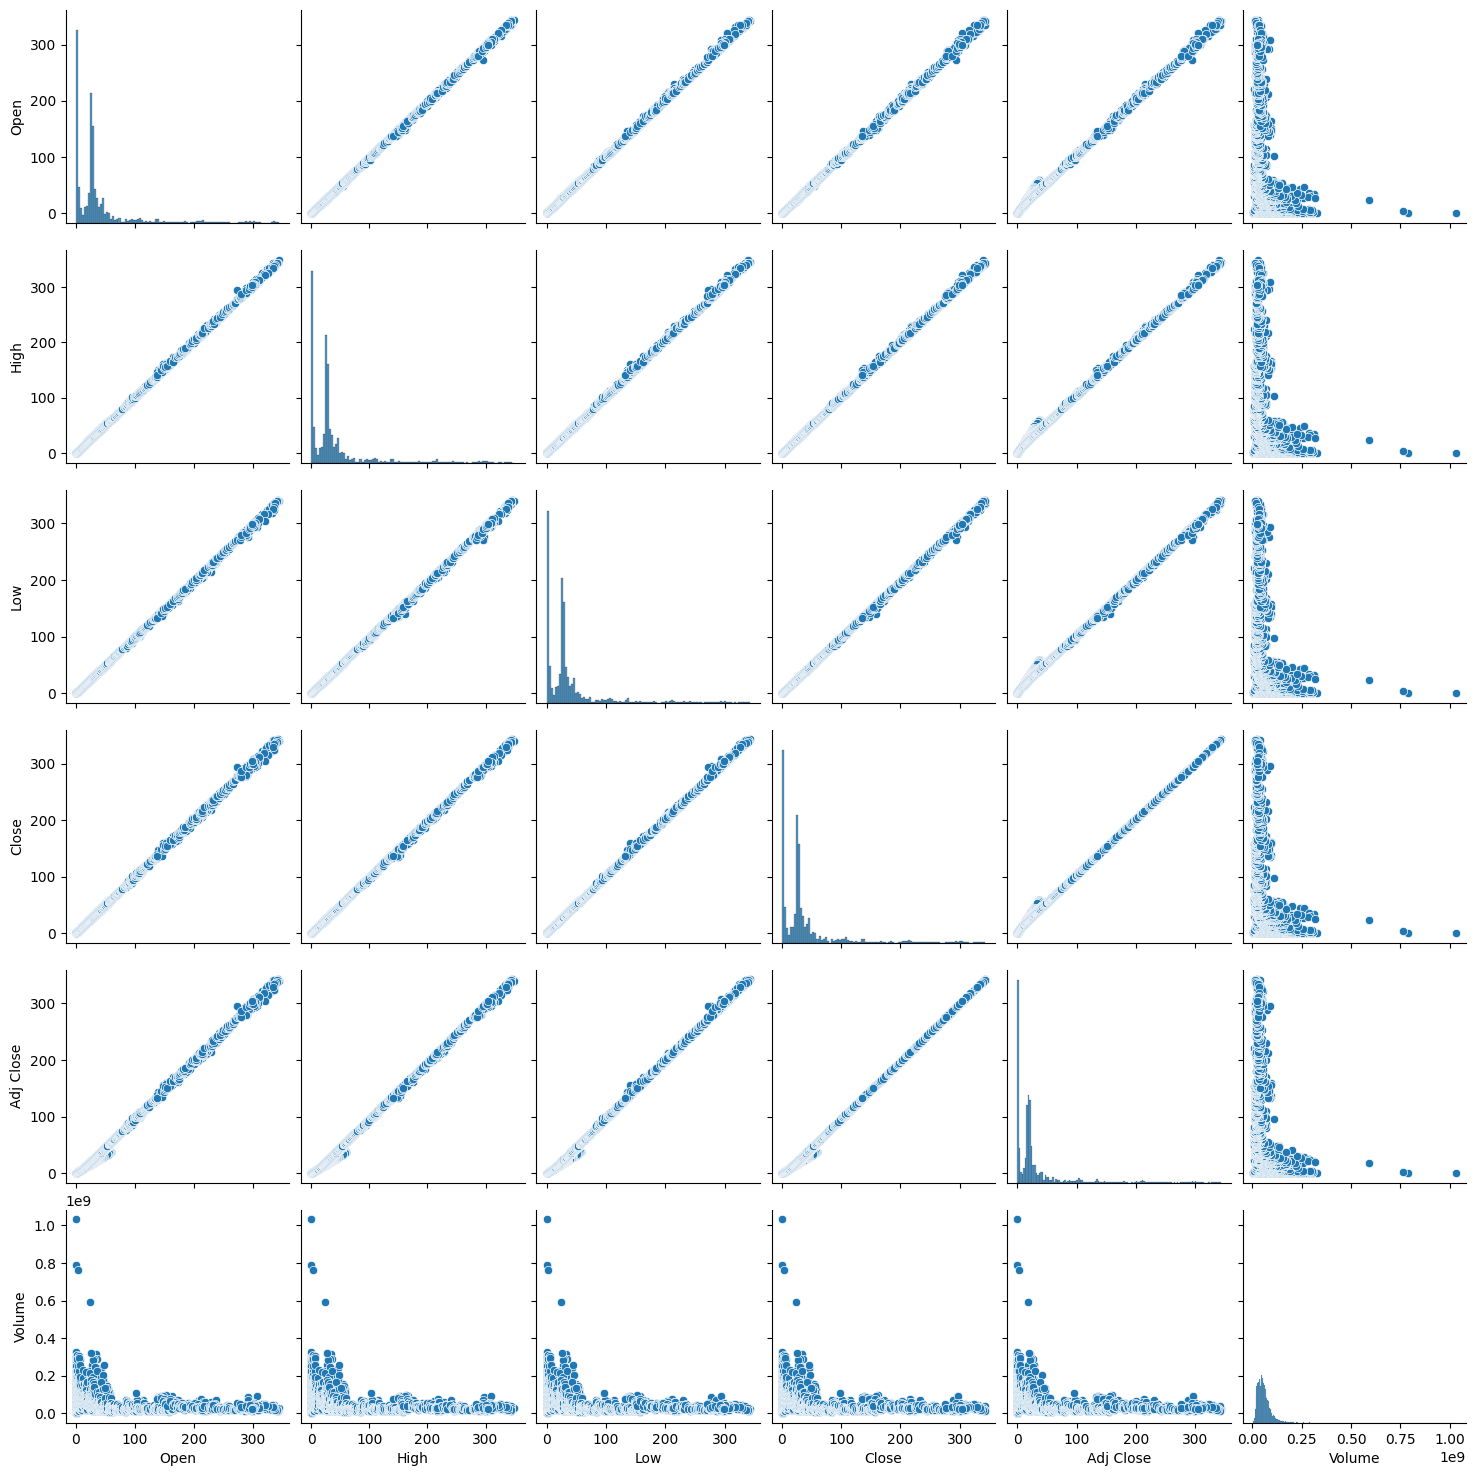

In [4]:
sns.pairplot(df)

<AxesSubplot:ylabel='Low'>

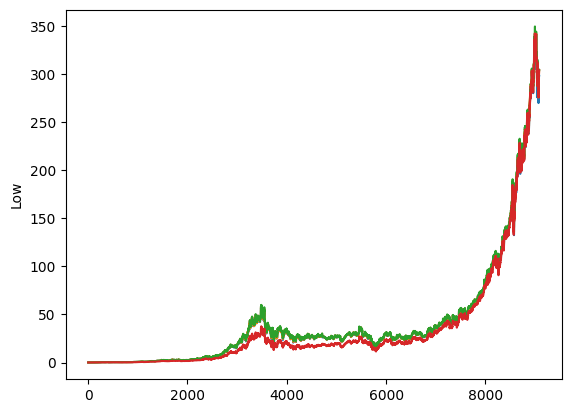

In [5]:
sns.lineplot(df['Low'])
sns.lineplot(df['Close'])
sns.lineplot(df['High'])
sns.lineplot(df['Adj Close'])

In [40]:
from sklearn.preprocessing import MinMaxScaler
price = df[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

C:\Users\HP\AppData\Local\Temp\ipykernel_10788\3492330880.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


In [41]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [42]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [32]:
from torch.nn import LSTM, Sequential
import torch.nn as nn
import torch

In [33]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [46]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

In [47]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [48]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  1.178270697593689
Epoch  1 MSE:  0.8862443566322327
Epoch  2 MSE:  0.6314018964767456
Epoch  3 MSE:  0.342550128698349
Epoch  4 MSE:  0.04467328265309334
Epoch  5 MSE:  0.168000727891922
Epoch  6 MSE:  0.16461090743541718
Epoch  7 MSE:  0.0658588856458664
Epoch  8 MSE:  0.011744066141545773
Epoch  9 MSE:  0.009960762225091457
Training time: 14.617993831634521


In [15]:
import pandas as pd
import seaborn as sns
import pmdarima as pm

In [87]:
df = pd.read_csv("tesla.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-03-02,142.251999,148.738007,137.334000,148.723999,148.723999,100975000
1,2020-03-03,161.000000,161.395996,143.222000,149.102005,149.102005,128920000
2,2020-03-04,152.792007,153.304001,144.945999,149.899994,149.899994,75245000
3,2020-03-05,144.753998,149.149994,143.613998,144.908005,144.908005,54263500
4,2020-03-06,138.000000,141.399994,136.854004,140.695999,140.695999,63314500
...,...,...,...,...,...,...,...
247,2021-02-23,662.130005,713.609985,619.000000,698.840027,698.840027,66606900
248,2021-02-24,711.849976,745.000000,694.169983,742.020020,742.020020,36767000
249,2021-02-25,726.150024,737.210022,670.580017,682.219971,682.219971,39023900
250,2021-02-26,700.000000,706.700012,659.510010,675.500000,675.500000,41011300


In [34]:
df = df.loc[:201,:]

In [35]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061434,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063628,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064725,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063079,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061982,47894400
...,...,...,...,...,...,...,...
197,1986-12-22,0.168403,0.171875,0.168403,0.170139,0.107510,18316800
198,1986-12-23,0.170139,0.171875,0.170139,0.171875,0.108607,23788800
199,1986-12-24,0.171875,0.171875,0.171007,0.171441,0.108332,7027200
200,1986-12-26,0.171441,0.172743,0.171007,0.171007,0.108058,3715200


In [88]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

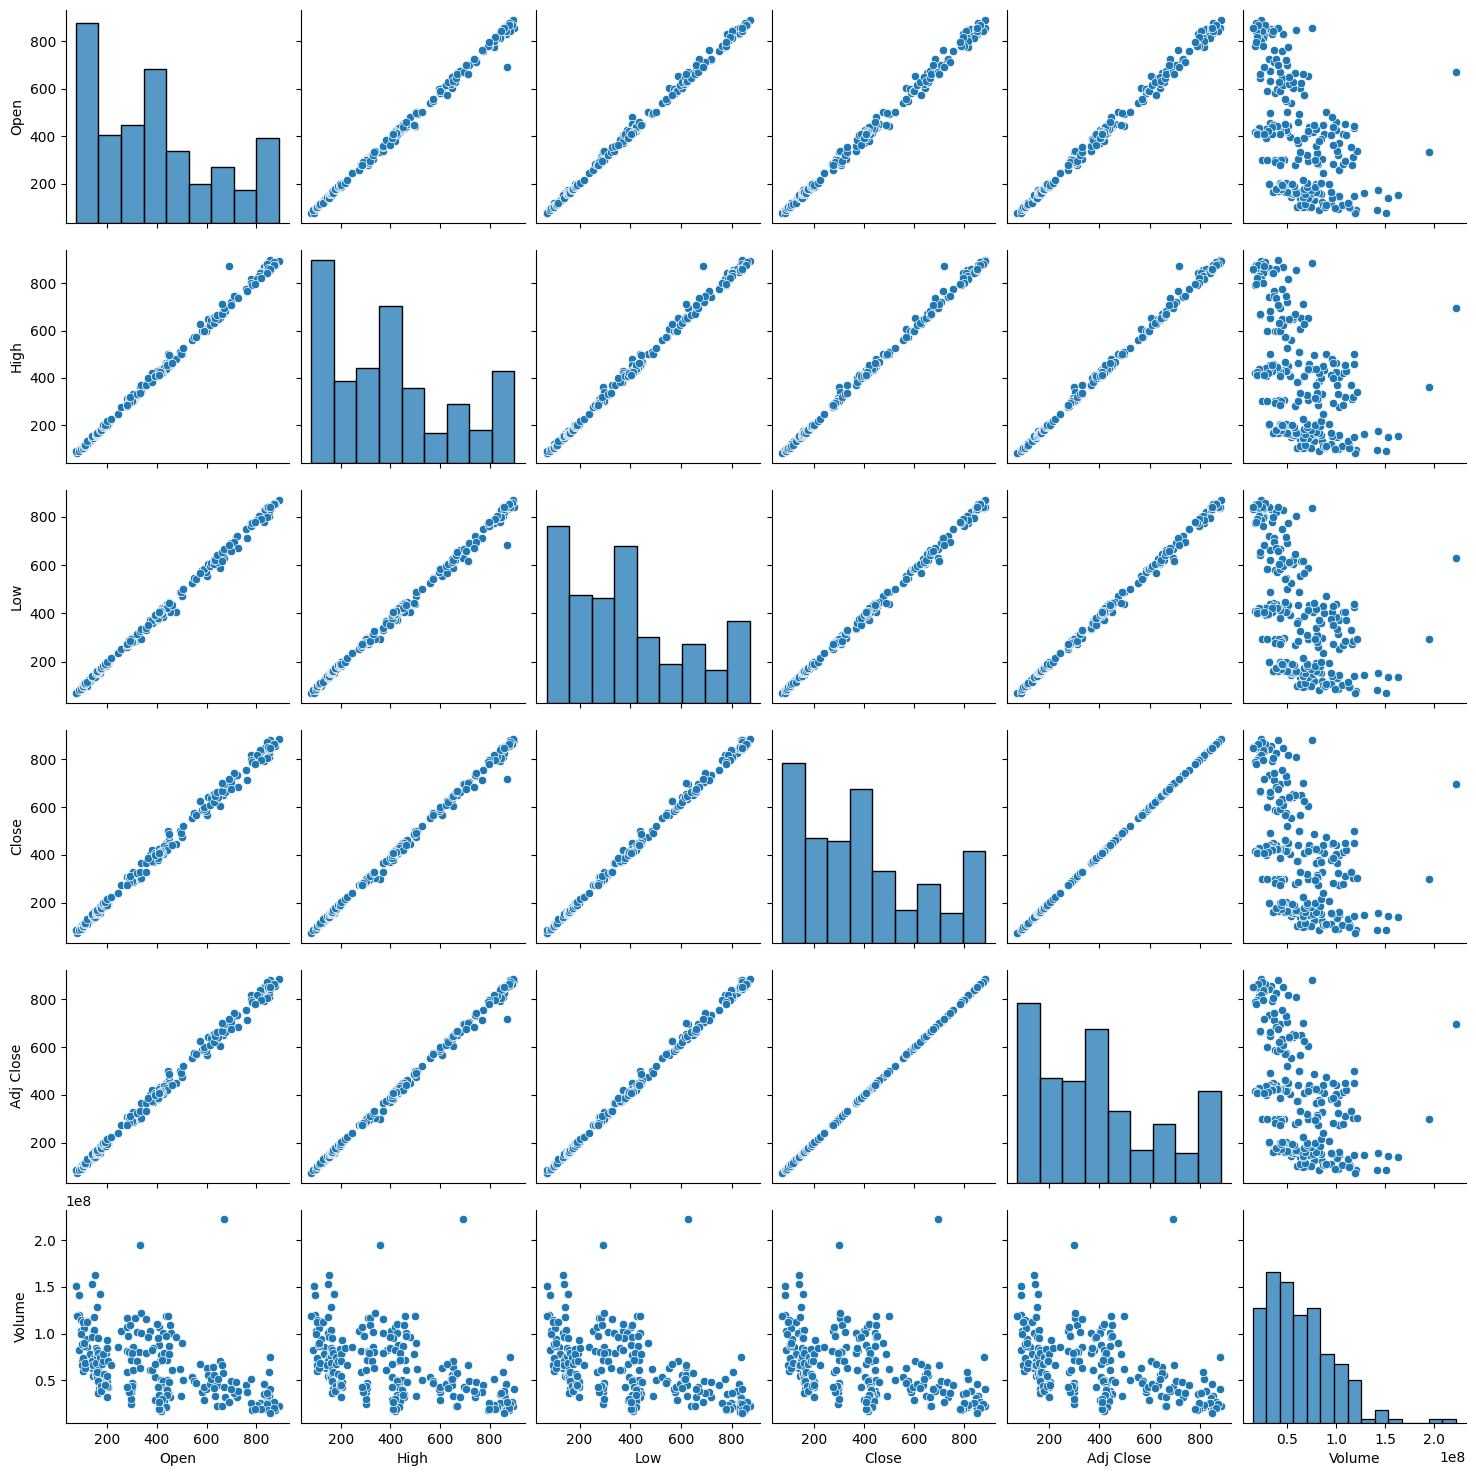

In [89]:
sns.pairplot(df)

<AxesSubplot:>

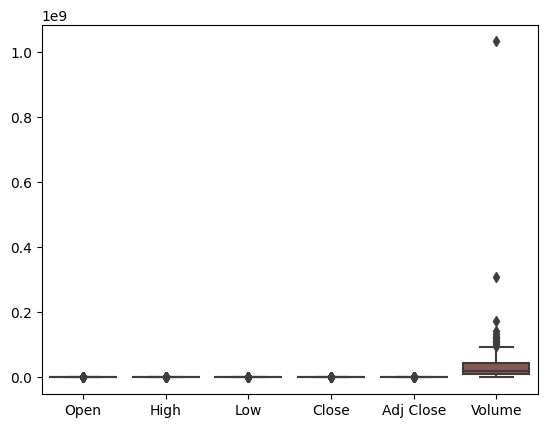

In [38]:
sns.boxplot(df)

<AxesSubplot:ylabel='Close'>

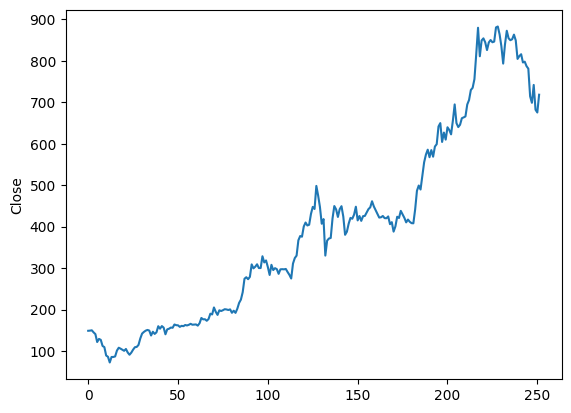

In [90]:
sns.lineplot(df['Close'])

In [96]:
df = df.loc[:,['Date','Close']]

KeyError: "['Date'] not in index"

In [ ]:
y = df.values
y

In [65]:
y.shape

(202, 1)

In [76]:
from pmdarima.model_selection import train_test_split
train,test = train_test_split(df['Passengers'],train_size=round((0.8*len(df))))

In [77]:
train

0      112
1      118
2      132
3      129
4      121
      ... 
110    362
111    348
112    363
113    435
114    491
Name: Passengers, Length: 115, dtype: int64

In [78]:
model = pm.auto_arima(train,m=12,seasonal=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


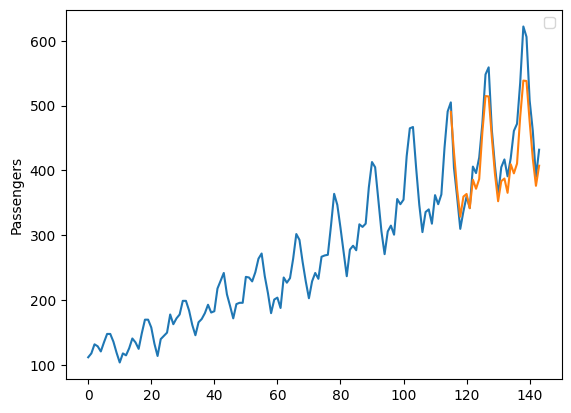

In [85]:
import matplotlib.pyplot as plt
import numpy as np
y_pred = model.predict(test.shape[0])
x = np.arange(y.shape[0])
sns.lineplot(x=x,y=df['Passengers'])
sns.lineplot(x=x[115:],y=y_pred)
plt.legend()